In [ ]:
import cv2
import numpy as np
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelBinarizer

# Constants
IMAGE_DIR = '/content/drive/MyDrive/miniii/train'  # Update this path
IMAGE_SIZE = 224

# Load annotations
annotations = pd.read_csv('/content/drive/MyDrive/miniii/train.csv')

# Parsing JSON data
annotations['region_shape_attributes'] = annotations['region_shape_attributes'].apply(json.loads)
annotations['region_attributes'] = annotations['region_attributes'].apply(lambda x: json.loads(x)['label'])

def get_bbox(attributes):
    if 'x' in attributes:
        x = attributes['x']
        y = attributes['y']
        width = attributes['width']
        height = attributes['height']
        return [x, y, x + width, y + height]
    return [0, 0, 1, 1]  # Default in case of missing data

annotations['bbox'] = annotations['region_shape_attributes'].apply(get_bbox)

# Label binarizer
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(annotations['region_attributes'])

def load_and_preprocess_image(filename, bbox):
    # Load image
    image_path = os.path.join(IMAGE_DIR, filename)
    image = cv2.imread(image_path)
    if image is None:
        return None, None  # If the image does not load properly
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

    # Normalize bbox coordinates
    orig_height, orig_width, _ = image.shape
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max = x_min / orig_width, x_max / orig_width
    y_min, y_max = y_min / orig_height, y_max / orig_height
    bbox = [x_min, y_min, x_max, y_max]

    return image, bbox

# Load all images and preprocess data
data = []
for idx, row in annotations.iterrows():
    img, bbox = load_and_preprocess_image(row['filename'], row['bbox'])
    if img is not None:
        data.append((img, bbox, labels[idx]))

if not data:
    raise Exception("No data loaded, check the paths and file names.")

# Splitting dataset
images, bboxes, class_labels = zip(*data)
images = np.array(images) / 255.0  # Normalize images
bboxes = np.array(bboxes)
class_labels = np.array(class_labels)

X_train, X_test, y_train_bbox, y_test_bbox, y_train_class, y_test_class = train_test_split(
    images, bboxes, class_labels, test_size=0.2, random_state=42
)



In [ ]:
def create_rcnn_model(num_classes):
    input_tensor = Input(shape=(224, 224, 3))
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    output_bbox = Dense(4, activation='linear', name='bbox')(x)  # Output for bounding box
    output_class = Dense(num_classes, activation='softmax', name='class')(x)  # Adjusted for the number of classes

    model = Model(inputs=input_tensor, outputs=[output_bbox, output_class])
    model.compile(optimizer='adam', loss={'bbox': 'mse', 'class': 'categorical_crossentropy'},
                  metrics={'bbox': 'mse', 'class': 'accuracy'})

    return model


In [ ]:
# Ensure the number of classes matches the final layer
num_classes = labels.shape[1]  # The number of classes based on the label binarizer
model = create_rcnn_model(num_classes)

# Training the model
history = model.fit(
    X_train, {'bbox': y_train_bbox, 'class': y_train_class},
    validation_data=(X_test, {'bbox': y_test_bbox, 'class': y_test_class}),
    batch_size=32,
    epochs=10,
    verbose=1
)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - bbox_mse: 18039.3516 - class_accuracy: 0.3484 - loss: 18067.8340 - val_bbox_mse: 1.1844 - val_class_accuracy: 0.3611 - val_loss: 2.4414
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step - bbox_mse: 1.0359 - class_accuracy: 0.3141 - loss: 2.5224 - val_bbox_mse: 2.9345 - val_class_accuracy: 0.3611 - val_loss: 4.3465
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 365ms/step - bbox_mse: 75.4957 - class_accuracy: 0.3363 - loss: 77.2807 - val_bbox_mse: 1.0909 - val_class_accuracy: 0.3889 - val_loss: 2.4701
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - bbox_mse: 0.9724 - class_accuracy: 0.3390 - loss: 2.3812 - val_bbox_mse: 0.4187 - val_class_accuracy: 0.3333 - val_loss: 1.6596
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - bbox_mse: 0.6581 - class_accuracy: 0.3884 - loss: 1.9857 - val_bbox_mse: 0.8914 - val_class_accuracy: 0.2222 - val_loss: 2.3301
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - bbox_mse: 0.6946 - class_accuracy: 0.309

In [ ]:
def load_and_preprocess_image_for_prediction(filename):
    image_path = os.path.join(IMAGE_DIR, filename)
    image = cv2.imread(image_path)
    if image is None:
        return None  # If the image does not load properly
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image) / 255.0  # Normalize the image
    return image

def predict_image(filename, model):
    image = load_and_preprocess_image_for_prediction(filename)
    if image is None:
        print("Failed to load image:", filename)
        return None
    image = np.expand_dims(image, axis=0)  # Expand dims to match the input shape (1, 224, 224, 3)
    predictions = model.predict(image)
    predicted_bbox, predicted_class = predictions
    predicted_bbox = predicted_bbox[0]  # Remove batch dimension
    predicted_class = predicted_class[0]
    return predicted_bbox, predicted_class



In [ ]:
# Example usage:
filename = '/content/drive/MyDrive/miniii/test/11cdea95-47b8-42e2-8501-35caa79eeef7_jpg.rf.eaa3083d5a5fe44292f21909d38f7fd5.jpg'  # Update this with your new image filename
predicted_bbox, predicted_class = predict_image(filename, model)

# Decoding the predictions
predicted_bbox = predicted_bbox * [IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE]  # Scale up bbox
predicted_class_id = np.argmax(predicted_class)  # Get the class ID with the highest probability
predicted_class_label = label_binarizer.classes_[predicted_class_id]  # Convert ID to label

print("Predicted Bounding Box:", predicted_bbox)
print("Predicted Class Label:", predicted_class_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Predicted Bounding Box: [ 36.91323137  30.53719091 105.19379616  52.93422222]
Predicted Class Label: alive


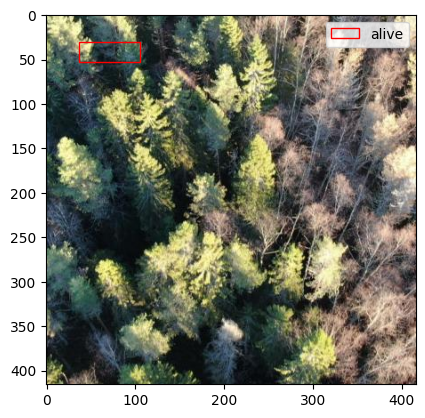

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image_with_bbox(image_path, bbox, class_label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Create a Rectangle patch
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1,
                             edgecolor='r', facecolor='none', label=class_label)
    ax.add_patch(rect)
    ax.legend()
    plt.show()

# Assuming 'predicted_bbox' is scaled to the original size of the image
display_image_with_bbox(os.path.join(IMAGE_DIR, filename), predicted_bbox, predicted_class_label)
